<a href="https://colab.research.google.com/github/manyajsingh/face-mask-detect-cvdl/blob/main/Face_Mask_Detection_CV_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-mask-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F809358%2F1386555%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240814%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240814T095019Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ede249a08b70869459410735b1968df85aa805a426a6f3c85228ef5cf2379b7b5f87abb6ba732f9101b0155aeaa6204eaf1d841e1b70bbe8930d3a87da8ab186286f3b3c4049a6c01d7c8d970d50c4e815e68e5c4418d072df50fc23bfcac0c50aae596310788c63f27ffbe76e2d85e5af6fca49034b39547f4a1c1a6ee28db364624f12002ef6bbcc183d6f4fcf4e0a446cbf673d6be2ead808ef7f26af048af4b18f9af0fc4510a2d88327dbddb329ba1f7df8a38b303bd05b6cbfe596e86f3fe90786270ee19d15486eaff444025c2023b4c419242ef991eca025930b9ce07dab9887d443ee3a6e174d3491f8000653172f5d2013b86214e24f7daf5258b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 171127690 bytes downloaded
Downloaded and uncompressed: face-mask-dataset
Data source import complete.




```
| Importing The Libraries


```



In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.utils import shuffle
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Flatten ,Dense ,Dropout ,BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50




```
| Loading The DataSet
```



In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/kaggle/input/face-mask-dataset/data"  ,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7553 files belonging to 2 classes.


In [5]:
len(dataset)

237

In [6]:
class_names = dataset.class_names
class_names

['with_mask', 'without_mask']



```
| Visualizing the Data
```



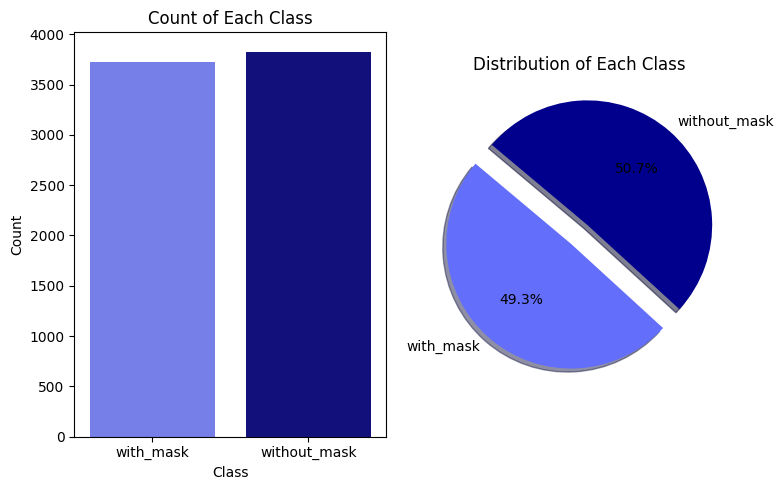

In [7]:
# Function to get all labels from a TensorFlow dataset
def get_all_labels(ds):
    labels = []
    for images_batch, labels_batch in ds:
        if isinstance(labels_batch, tf.Tensor):
            labels.extend(labels_batch.numpy())
        else:
            print("Unexpected format in labels_batch:", type(labels_batch))
    return labels

# Get all labels from the dataset
labels = get_all_labels(dataset)

# Count the occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}
for label in labels:
    class_counts[class_names[label]] += 1

# Create a DataFrame for visualization
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Define colors
colors = ['#636efb', '#01008c']

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(8,5))

# Create count plot using seaborn
sns.barplot(x='Class', y='Count', data=df, palette=colors, ax=axes[0])
axes[0].set_title('Count of Each Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Create pie chart using matplotlib
axes[1].pie(df['Count'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=colors, shadow=True, explode=[0.1]*len(df))
axes[1].set_title('Distribution of Each Class')

# Show the plots
plt.tight_layout()
plt.show()


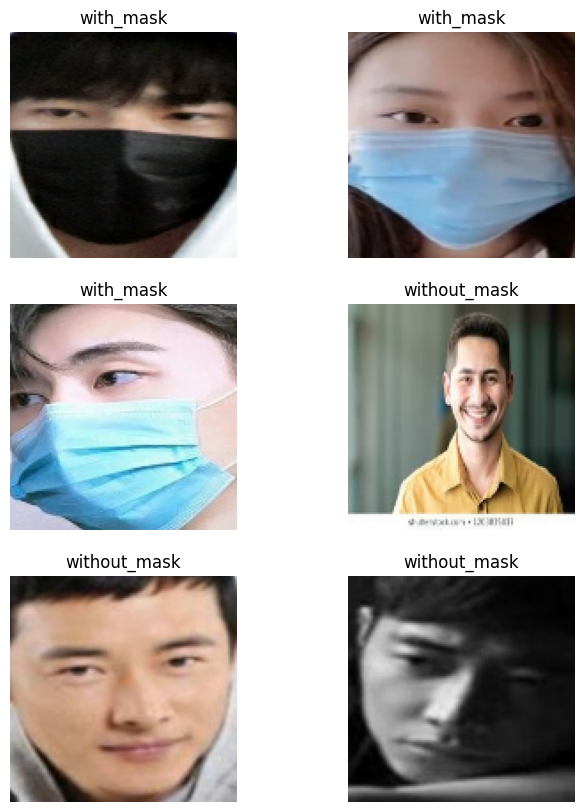

In [8]:
plt.figure(figsize=(8, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3,2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [9]:
image_batch[0].shape

TensorShape([128, 128, 3])



```
| Split The DataSet
```



In [10]:
# | Function to Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)


    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print(len(train_ds))         #189+23+25=237
print(len(val_ds))
print(len(test_ds))

189
23
25


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])



```
| Modeling
```



In [14]:
# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Load ResNet152V2 model without top layers and with pre-trained weights
base_model = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

# Create a new model
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(rate=0.2),
    Dense(2, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Test with a dummy input to confirm shapes
dummy_input = tf.keras.Input(shape=input_shape)
model(dummy_input)  # This will help to build the model


<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_578>

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 4, 4, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,894,402 (255.18 MB)

 Trainable params: 66,684,354 (254.38 MB)

 Non-trainable params: 210,048 (820.50 KB)

In [ ]:
# confusion matrix
# heat map
# precision
# recall score
# f1 score
# matthew correlation coefficient
# roc curve and auc
# pr curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


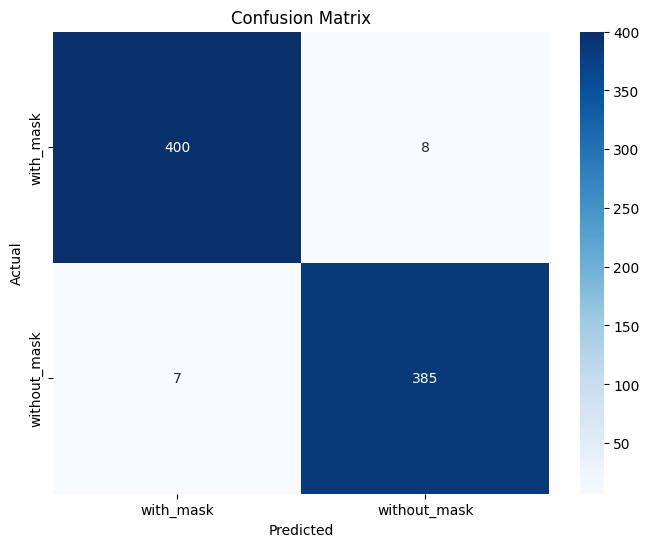

              precision    recall  f1-score   support

   with_mask       0.98      0.98      0.98       408
without_mask       0.98      0.98      0.98       392

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [18]:
# Function to get the predictions and true labels
def get_predictions_and_labels(model, dataset):
    predictions = []
    true_labels = []
    for images_batch, labels_batch in dataset:
        batch_predictions = model.predict(images_batch)
        batch_predictions = np.argmax(batch_predictions, axis=-1)
        predictions.extend(batch_predictions)
        true_labels.extend(labels_batch.numpy())
    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels for the test dataset
predictions, true_labels = get_predictions_and_labels(model, test_ds)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predictions, target_names=class_names))


Text(0, 0.5, 'True')

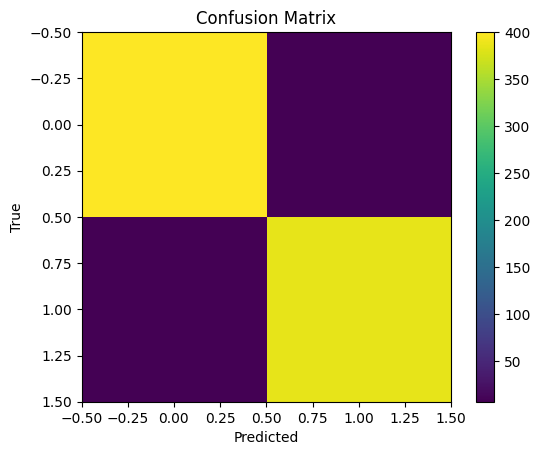

In [19]:
#heat map
plt.imshow(cm, cmap='viridis', alpha=1)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

In [20]:
#precision
#Precision Score = True Positives/ (False Positives + True Positives)
from sklearn.metrics import precision_score
print('Precision: %.3f' % precision_score(true_labels, predictions)) # Use 'predictions' instead of 'predicted_labels'

Precision: 0.980


In [21]:
#recall score
#Recall Score = True Positives / (False Negatives + True Positives)
from sklearn.metrics import recall_score # Import the recall_score function
print('Recall: %.3f' % recall_score(true_labels, predictions)) # Calculate recall score using true and predicted labels

Recall: 0.982


In [22]:
#f1 score
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score)
from sklearn.metrics import f1_score # Import the f1_score function

print('F1 Score: %.3f' % f1_score(true_labels, predictions)) # Calculate F1 score using true and predicted labels

F1 Score: 0.981


In [23]:
#matthew correlation coefficient
from sklearn.metrics import matthews_corrcoef # Import the matthews_corrcoef function
mcc=matthews_corrcoef(true_labels, predictions, sample_weight=None) # Use true_labels and predictions
print("Matthew correlation coefficient: %.3f" % mcc)

Matthew correlation coefficient: 0.962


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

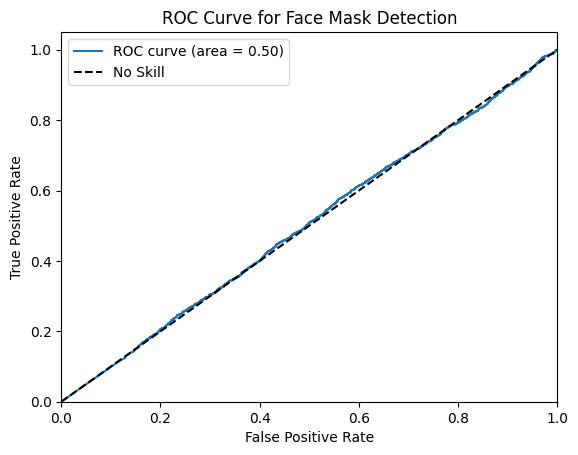

In [24]:
#roc
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import numpy as np # Import numpy for array manipulation

# Extract data from TensorFlow datasets into NumPy arrays
y_true = np.concatenate([y for x, y in train_ds], axis=0)

# Ensure that predictions are generated for the same dataset as y_true
y_score = np.concatenate([model.predict(x) for x, y in train_ds], axis=0)

# Select probabilities for the positive class (assuming it's the second column)
y_score = y_score[:, 1] # Extract probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score) # Use NumPy arrays here
roc_auc = auc(fpr, tpr)

# Plot the ROC curve (rest of the code remains the same)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Face Mask Detection')
plt.legend()
plt.show()

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

print("Model fitting completed.")

# Check if training completed successfully
if history is None:
    print("Error: Model training failed. Check for issues with your data or model configuration.")
else:
    # Proceed with analyzing the training history
    print(history.history)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 279s 655ms/step - accuracy: 0.8642 - loss: 0.3055 - val_accuracy: 0.9755 - val_loss: 0.0622
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 50s 264ms/step - accuracy: 0.9747 - loss: 0.0785 - val_accuracy: 0.9932 - val_loss: 0.0210
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.9919 - loss: 0.0268 - val_accuracy: 0.9973 - val_loss: 0.0136
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 0.9878 - val_loss: 0.0328
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 50s 263ms/step - accuracy: 0.9943 - loss: 0.0168 - val_accuracy: 0.9959 - val_loss: 0.0217
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 84s 275ms/step - accuracy: 0.9973 - loss: 0.0109 - val_accuracy: 0.9959 - val_loss: 0.0242
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 80s 266ms/step - accuracy: 0.9960 - loss: 0.0131 - val_accuracy: 0.9932 - val_loss: 0.0250
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 50s 265ms/step - accuracy: 0.9897 - loss: 



```
| Model Evaluation
```



In [25]:
scores = model.evaluate(test_ds)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9820 - loss: 0.1965




```
| Plotting the accuracy and loss curves
```



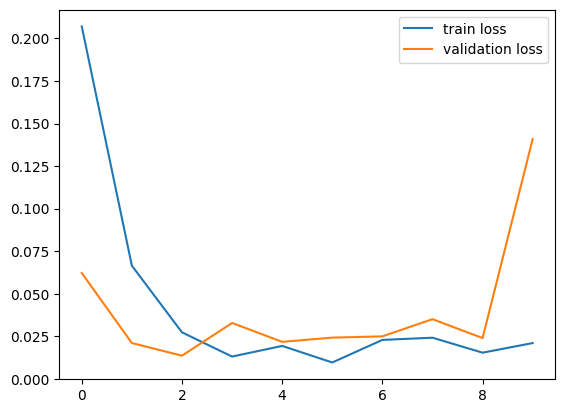

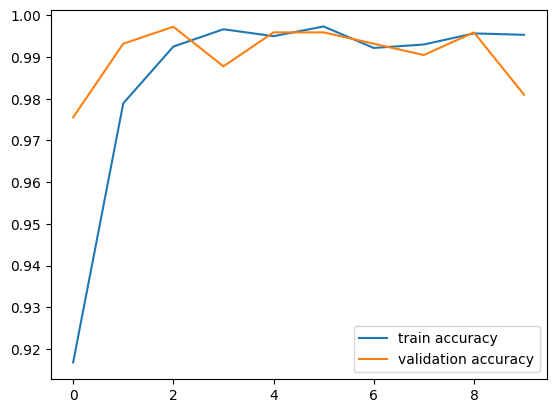

In [26]:
h = history
# plot the loss value
plt.plot(h.history['loss'],
         label='train loss')
plt.plot(h.history['val_loss'],label='validation loss')
plt.legend()
plt.show()
# plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()



```
| Predict Image
```



first image to predict
actual label: without_mask
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted label: without_mask


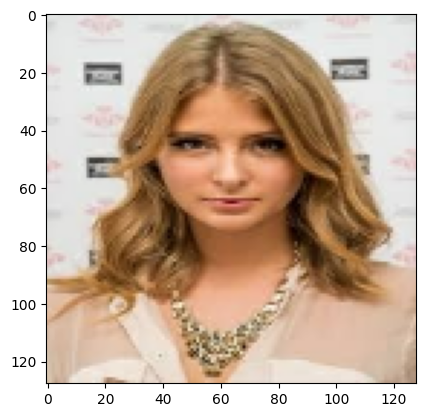

In [27]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    test_ds = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return test_ds, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


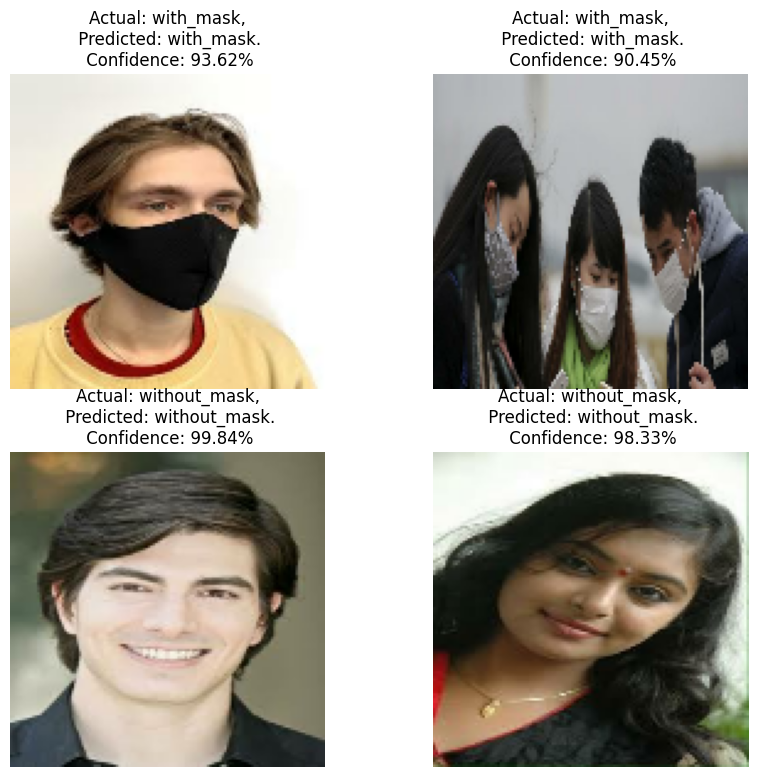

In [29]:
plt.figure(figsize=(10,9))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        test_ds, confidence = predict(model, images[i].numpy())
        train_ds = class_names[labels[i]]

        plt.title(f"Actual: {train_ds},\n Predicted: {test_ds}.\n Confidence: {confidence}%")

        plt.axis("off")